# Is Malaga Sunnier than Warsaw?

In [11]:
import requests
import datetime
import json
import os

def fetch_weather_data(api_key, lat, lon, date):
    filename = f"data/day_summary_lat{lat}_lon{lon}_date{date.strftime('%Y%m%d')}.json"

    os.makedirs('./data', exist_ok=True)
    if os.path.exists(filename):
        with open(filename, 'r') as file:
            return json.load(file)

    base_url = "https://api.openweathermap.org/data/3.0/onecall/day_summary"
    params = {
        'appid': api_key,
        'lat': lat,
        'lon': lon,
        'date': date.strftime('%Y-%m-%d')
    }
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            with open(filename, 'w') as file:
                json.dump(data, file)

            return data
        else:
            print(f"Failed to fetch data for {date.strftime('%Y-%m-%d')}: HTTP Status Code {response.status_code}")
            return None
    except requests.RequestException as e:
        print(f"Request failed for {date.strftime('%Y-%m-%d')}: {e}")
        return None

def process_weather_data(api_key, lat, lon, start_date, end_date):
    sunny_days = []
    current_date = start_date
    while current_date <= end_date:
        weather_data = fetch_weather_data(api_key, lat, lon, current_date)
        if weather_data:
            cloud_cover = weather_data['cloud_cover']['afternoon']
            total_precipitation = weather_data['precipitation']['total']

            is_sunny = cloud_cover < 20 and total_precipitation < 1
            print(f"{lat},{lon},{current_date.strftime('%Y-%m-%d')},{cloud_cover}%,{total_precipitation}mm,{is_sunny}")
            if is_sunny:
                sunny_days.append(current_date)

        current_date += datetime.timedelta(days=1)
    return sunny_days


## Lets Download and Process The Weather Data

In [13]:
api_key = input("Pass the API KEY from https://home.openweathermap.org/api_keys, or skip to load the local data")

# Warsaw, Poland
lat_warsaw, lon_warsaw = 52.2297, 21.0122
# Malaga, Spain
lat_malaga, lon_malaga = 36.7213, -4.4214

start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

sunny_days_warsaw = process_weather_data(api_key, lat_warsaw, lon_warsaw, start_date, end_date)
sunny_days_malaga = process_weather_data(api_key, lat_malaga, lon_malaga, start_date, end_date)

## Then Create a Heatmap

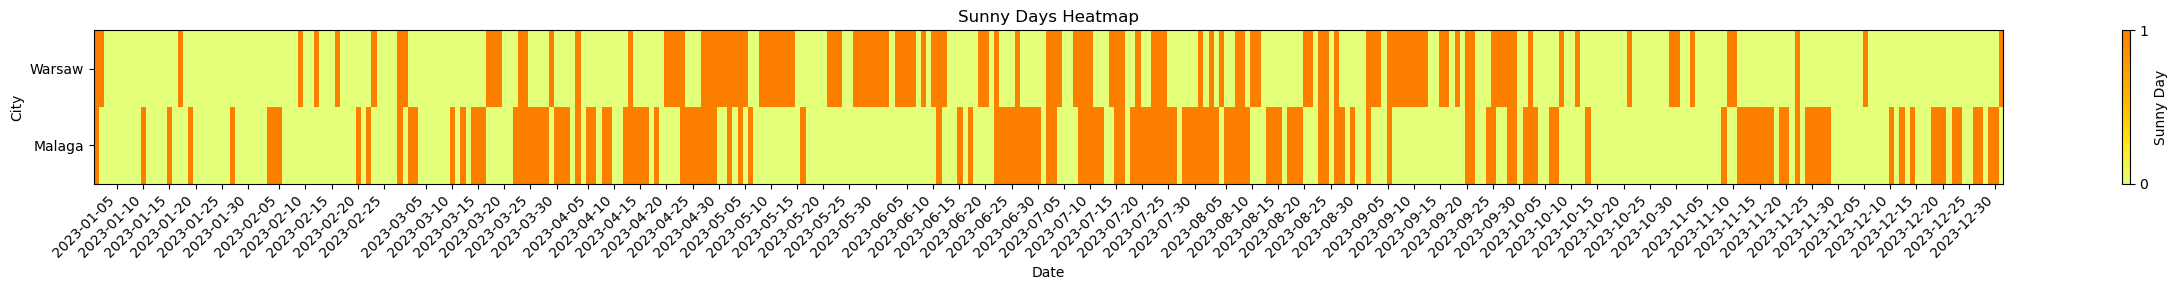

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

def create_heatmap(city_data, city_names, start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    data = np.zeros((len(city_data), len(dates)))

    for i, city_sunny_days in enumerate(city_data):
        data[i] = [1 if date in city_sunny_days else 0 for date in dates]

    fig, ax = plt.subplots(figsize=(25, 3))
    cax = ax.imshow(data, aspect='auto', cmap='Wistia', interpolation='nearest')

    ax.set_yticks(np.arange(len(city_names)))
    ax.set_yticklabels(city_names)

    xticks_labels = [date.strftime('%Y-%m-%d') for date in dates if date.day%5==0]
    xticks_positions = [i for i, date in enumerate(dates) if date.day%5==0]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels, rotation=45, ha='right')

    ax.set_xlabel('Date')
    ax.set_ylabel('City')
    ax.set_title('Sunny Days Heatmap')

    plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 1], label='Sunny Day')
    plt.tight_layout()
    plt.show()


create_heatmap([sunny_days_warsaw, sunny_days_malaga], ['Warsaw', 'Malaga'], start_date, end_date)


## Finally Calculate The Monthly Sunny Days Plot

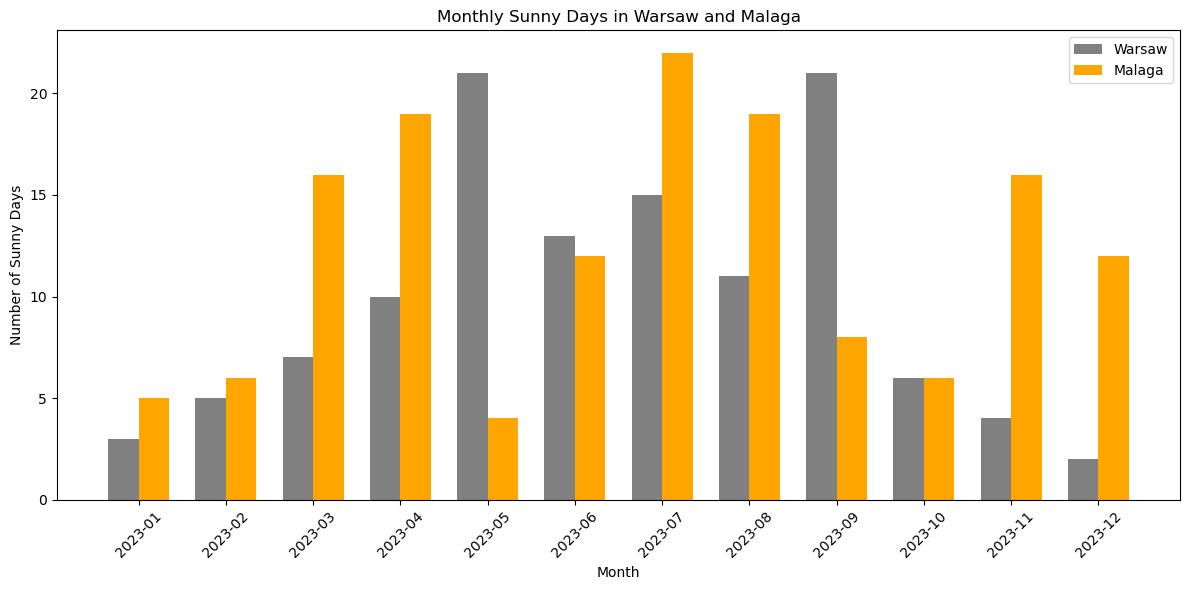

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import datetime

def plot_monthly_average_sunniness(city1_data, city2_data, city1_name, city2_name, start_date, end_date):
    def calculate_sunny_days_per_month(sunny_days, start_date, end_date):
        total_months = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month + 1
        monthly_counts = [0] * total_months

        for day in sunny_days:
            if start_date <= day <= end_date:
                month_index = (day.year - start_date.year) * 12 + day.month - start_date.month
                monthly_counts[month_index] += 1
        return monthly_counts

    city1_monthly_sunny = calculate_sunny_days_per_month(city1_data, start_date, end_date)
    city2_monthly_sunny = calculate_sunny_days_per_month(city2_data, start_date, end_date)

    total_months = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month + 1
    months = np.arange(total_months)
    month_labels = [(start_date + pd.DateOffset(months=i)).strftime('%Y-%m') for i in range(total_months)]

    plt.figure(figsize=(12, 6))
    bar_width = 0.35

    plt.bar(months - bar_width/2, city1_monthly_sunny, bar_width, color='grey', label=city1_name)
    plt.bar(months + bar_width/2, city2_monthly_sunny, bar_width, color='orange', label=city2_name)

    plt.xlabel('Month')
    plt.ylabel('Number of Sunny Days')
    plt.title('Monthly Sunny Days in ' + city1_name + ' and ' + city2_name)
    plt.xticks(months, month_labels, rotation=45)
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_monthly_average_sunniness(sunny_days_warsaw, sunny_days_malaga, 'Warsaw', 'Malaga', start_date, end_date)
